In [1]:
import numpy as np
import numpy.random as nrd
import matplotlib.pyplot as plt

import tensorflow as tf

from collections import defaultdict

# Exercise 11.5

(a) Write a program to fit a single hidden layer neural network (ten hidden units) via back-propagation and weight decay.

(b) Apply it to 100 observations from the model Y = σ(a^T_1 X) + (a^T_2 X)^2 + 0.30 · Z, where σ is the sigmoid function, Z is standard normal, X^T = (X1,X2), each Xj being independent standard normal, and a1 = (3, 3), a2 = (3,−3). Generate a test sample of size 1000, and plot the training and test error curves as a function of the number of training epochs, for different values of the weight decay parameter. Discuss the overfitting behavior in each case.

(c) Vary the number of hidden units in the network, from 1 up to 10, and determine the minimum number needed to perform well for this task.

# Solution

We implement a simple NN following Sec 11 in the main text,

In [2]:
def sigmoid(X):
    return 1/(1+np.exp(-X))

class SingleHiddenNN():
    
    def __init__(self,hidden_size,learning_parameter,regularisation_parameter):
        
        self.M = hidden_size
        self.gamma = learning_parameter
        self.lamb = regularisation_parameter
        
        self.with_test_set = False
        
        # Currently we are interested in regression, but we might want to extend this.
        self.K = 1
        self.g = lambda x : x
        
    def add_test_set(self,X,y):
        
        self.with_test_set = True
        self.X_test = X
        self.y_test = y
        
    def initialize_weights(self):
        
        self.alpha = nrd.rand(self.p+1,self.M)
        self.beta = nrd.rand(self.M+1,self.K)
        
    def loss_function(self,X,y):
        N = y.size
        res = y - self.predict(X)
        loss = np.mean(res**2)
        return loss
    
    def forward_pass(self,X):
        
        N,_ = X.shape
        
        Z = sigmoid(X @ self.alpha)
        Z = np.hstack((np.ones(shape=(N,1)),Z))
        y_forward = self.g(Z @ self.beta)
        
        return Z, y_forward
    
    def backward_pass(self,z,y_pred,y_exp):
        
        # Error for the output nodes
        delta = -2 * (y_exp - y_pred)
        
        # Error for the hidden nodes
        sig = sigmoid(z)
        s = delta * sig * (1-sig) * self.beta
        s = s[1:]
        
        return delta, s
    
    def loss_gradient(self,X,y,Z,y_forward):
        
        # Regularization component of gradient
        grad_beta = 2 * self.lamb * self.beta
        grad_alpha = 2 * self.lamb * self.alpha
        
        # Backward pass through the network
        for x,y_exp,z,y_pred in zip(X,y,Z,y_forward):

            z = np.reshape(z,(self.M+1,1))
            x = np.reshape(x,(self.p+1,1))

            # Backward propagarion of the errors
            delta, s = self.backward_pass(z,y_pred,y_exp)

            # Gradient update
            grad_beta += delta * z
            grad_alpha += x @ s.T
            
        return grad_alpha, grad_beta
    
    def fit(self,X,y,epochs):
        
        N, self.p = X.shape
        self.initialize_weights()
        
        X = np.hstack((np.ones(shape=(N,1)),X))
        history = defaultdict(list)
        
        for _ in range(epochs):
        
            # Forward pass through the network
            Z,y_forward = self.forward_pass(X)
            
            # Compute the loss function
            loss = np.mean((y - y_forward)**2)
            history['train'].append(loss)
            
            # If we added a test set
            if self.with_test_set:
                loss_test = self.loss_function(self.X_test,self.y_test)
                history['test'].append(loss_test)
            
            # Compute gradient (with regularization)
            grad_alpha, grad_beta = self.loss_gradient(X,y,Z,y_forward)
            
            # Update weights
            self.beta -= self.gamma * grad_beta
            self.alpha -= self.gamma * grad_alpha
            
        self.history = history
        
    def predict(self,X):
        N,_ = X.shape
        X = np.hstack((np.ones(shape=(N,1)),X))
        _, y = self.forward_pass(X)
        return y

### Data

In [3]:
def y_dependence(X):
    N,_ = X.shape
    epsilon = nrd.normal(size=N)
    
    a1 = np.array([3,3])
    a2 = np.array([3,-3])
    c1 = 0.3

    return np.reshape(sigmoid(X @ a1) + (X @ a2)**2 + c1 * epsilon,(N,1))

In [4]:
N_train = 100
N_test = 1000
p = 2

# Training set
X_train = nrd.normal(size=(N_train,p))
y_train = y_dependence(X_train)

# Test set
X_test = nrd.normal(size=(N_test,p))
y_test = y_dependence(X_test)

### Training

We train the NN with 10 hidden nodes, and different values for regularization. We find that a regularization around $\lambda = 50$ seems to generalize best.

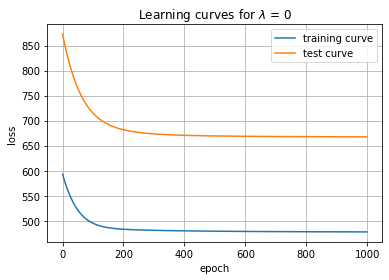

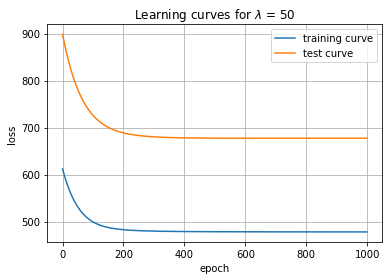

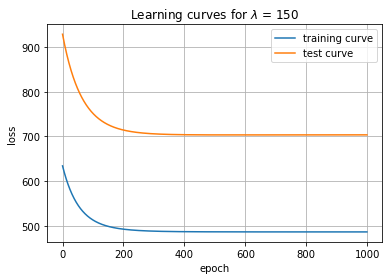

In [5]:
M = 10
gamma = 1e-5 # learning parameter
lambs = [0,50,150] # different regularization values
epochs_num = 1000

for lamb in lambs:
    regression_nn = SingleHiddenNN(M,gamma,lamb)
    regression_nn.add_test_set(X_test,y_test)
    regression_nn.fit(X_train,y_train,epochs_num)
    
    learning_curve_train = regression_nn.history['train']
    learning_curve_test = regression_nn.history['test']
    
    plt.plot(learning_curve_train,label='training curve')
    plt.plot(learning_curve_test,label='test curve')
    plt.title('Learning curves for $\lambda$ = {}'.format(lamb))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

### Checking how the fit changes as a function of the number of hidden layers

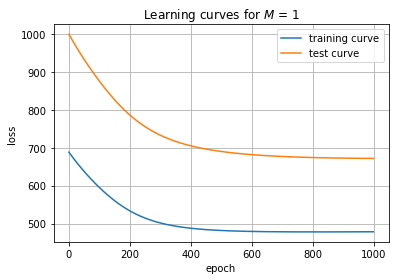

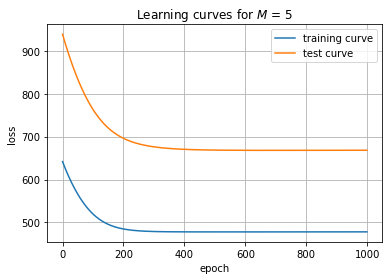

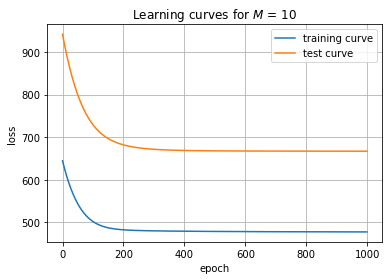

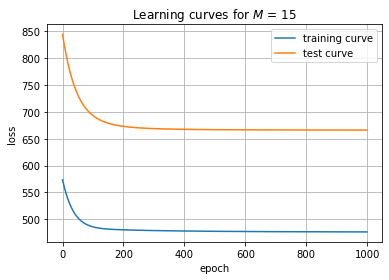

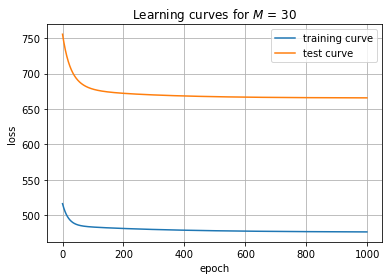

In [6]:
Ms = [1,5,10,15,30]
gamma = 1e-5 # learning parameter
lamb = 0 # different regularization values
epochs_num = 1000

for M in Ms:
    regression_nn = SingleHiddenNN(M,gamma,lamb)
    regression_nn.add_test_set(X_test,y_test)
    regression_nn.fit(X_train,y_train,epochs_num)
    
    learning_curve_train = regression_nn.history['train']
    learning_curve_test = regression_nn.history['test']
    
    plt.plot(learning_curve_train,label='training curve')
    plt.plot(learning_curve_test,label='test curve')
    plt.title('Learning curves for $M$ = {}'.format(M))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

### Comparison using TensorFlow

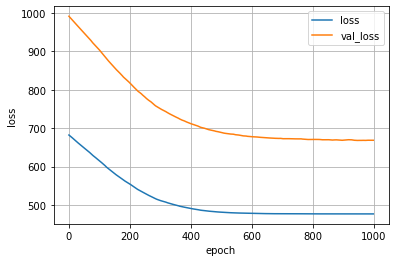

In [7]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10,activation='sigmoid'))
model.add(tf.keras.layers.Dense(1))

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error'
)

history = model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    verbose=False,
    epochs=1000)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()

Interesting how TensorFlow seems not to need a regularization in the weights to get somthing stable, in particular its test error does not grow after reaching a minimum.